In [1]:
import pandas as pd
import numpy as np
import random
from transformers import pipeline
import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

/Users/apple/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Game Context Setup: Map the columns of your dataframe to the modified battleship game rules.
- Columns like bin, type, paras, etc., can be associated with specific game states or parameters.
2. Question Evaluation: Use the text or full column as questions generated by LLMs or humans, and evaluate their quality using Expected Information Gain (EIG).
3. Integration with Metrics: Compute metrics like EIG for each question in the dataframe and add a new column for these scores.
4. Comparison: Analyze the scores to compare human-generated vs. LLM-generated questions.

In [2]:
df = pd.read_csv('df.allBySubj.csv')
df.head()

,trial,subj,bin,type,paras,para_1,para_2,para_3,full,text
0,1,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?
1,2,7,horizontal(purple),horizontal,3,3.0,NaN,NaN,Is the purple ship horizontal?,Is the purple ship laying horizontal?
2,3,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?
3,4,7,horizontal(blue),horizontal,1,1.0,NaN,NaN,Is the blue ship horizontal?,Is the blue ship vertical
4,5,7,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,How many blocks is the purple ship?


In [3]:
df.describe(include='all')

,trial,subj,bin,type,paras,para_1,para_2,para_3,full,text
count,605.000000,605.000000,605,605,578,578.000000,204.000000,31.000000,605,605
unique,NaN,NaN,139,35,58,NaN,NaN,NaN,139,395
top,NaN,NaN,shipsize(red),shipsize,2,NaN,NaN,NaN,How many tiles is the red ship?,How long is the red ship?
freq,NaN,NaN,66,185,129,NaN,NaN,NaN,66,14
mean,9.570248,51.008264,NaN,NaN,NaN,2.271626,2.867647,1.967742,NaN,NaN
std,5.205108,19.788993,NaN,NaN,NaN,1.273891,1.330629,0.795147,NaN,NaN
min,1.000000,7.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN
25%,5.000000,39.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000,NaN,NaN
50%,9.000000,57.000000,NaN,NaN,NaN,2.000000,3.000000,2.000000,NaN,NaN
75%,14.000000,67.000000,NaN,NaN,NaN,3.000000,4.000000,3.000000,NaN,NaN


# Setting up the game environment
Create a grid-based battleship game with modified rules.

In [4]:
# Battleship game setup
class BattleshipGame:
    def __init__(self, grid_size=6, ships=None):
        self.grid_size = grid_size
        self.grid = np.zeros((grid_size, grid_size))
        self.ships = ships if ships else self._generate_ships()

    def _generate_ships(self):
        # Example predefined ships (can be randomized as needed)
        ships = [
            {'color': 'red', 'length': 3, 'orientation': 'horizontal', 'start': (1, 2)},
            {'color': 'blue', 'length': 2, 'orientation': 'vertical', 'start': (4, 1)},
            {'color': 'purple', 'length': 4, 'orientation': 'horizontal', 'start': (5, 0)},
        ]
        for ship in ships:
            x, y = ship['start']
            for i in range(ship['length']):
                if ship['orientation'] == 'horizontal':
                    self.grid[x, y + i] = 1
                else:
                    self.grid[x + i, y] = 1
        return ships

    def query_tile(self, x, y):
        return "hit" if self.grid[x, y] == 1 else "miss"

# Initialize the game
game = BattleshipGame()


In [5]:
# Generate hypothesis space
def generate_hypothesis_space(grid_size=6, num_hypotheses=100):
    """
    Generate a list of random grid configurations representing possible game states.
    """
    return [np.random.randint(0, 2, size=(grid_size, grid_size)) for _ in range(num_hypotheses)]

hypothesis_space = generate_hypothesis_space()


# Bayesian Ideal Observer Model
Implement the ideal observer to calculate the expected information gain (EIG) for each possible question.

In [7]:
from scipy.stats import entropy

def calculate_eig(hypothesis_space, question_function):
    """
    Calculate Expected Information Gain (EIG) for a given question.
    
    Parameters:
    hypothesis_space : list or numpy array
        The set of possible hypotheses (e.g., possible game configurations).
    question_function : function
        A function that takes in the hypothesis space and returns potential answers.
        
    Returns:
    float
        The calculated Expected Information Gain (EIG) for the question.
    """
    
    # Step 1: Prior probabilities (uniform distribution over hypothesis space)
    num_hypotheses = len(hypothesis_space)
    prior_probs = np.ones(num_hypotheses) / num_hypotheses

    # Step 2: Simulate answers for the given question
    answers = question_function(hypothesis_space)
    unique_answers, counts = np.unique(answers, return_counts=True)
    answer_probs = counts / num_hypotheses  # Probability of each answer

    # Step 3: Calculate posterior probabilities for each possible answer
    posterior_probs_list = []
    
    for answer in unique_answers:
        # Likelihood function: p(d|h; x)
        likelihood = np.array([1 if a == answer else 0 for a in answers])
        
        # Posterior calculation using Bayes' rule
        posterior = likelihood * prior_probs
        posterior /= posterior.sum() if posterior.sum() > 0 else 1  # Avoid division by zero
        posterior_probs_list.append(posterior)
    
    # Step 4: Calculate prior entropy
    prior_entropy = entropy(prior_probs)

    # Step 5: Calculate expected posterior entropy
    expected_posterior_entropy = 0
    for posterior, prob in zip(posterior_probs_list, answer_probs):
        expected_posterior_entropy += prob * entropy(posterior)

    # Step 6: Compute Expected Information Gain (EIG)
    eig = prior_entropy - expected_posterior_entropy

    return eig


# Dynamic Question Function
Each row in the dataframe contains a question (text) which should dynamically define the question function based on the content of the bin, type, or text column.

In [8]:
def dynamic_question_function(row):
    """
    Create a question function based on the row's content.
    """
    bin_info = row['bin']
    type_info = row['type']

    # Example: Question about whether a specific area is occupied
    if "red" in bin_info and type_info == "shipsize":
        return lambda h: ["yes" if h[1, 2] == 1 else "no" for h in hypothesis_space]
    elif "blue" in bin_info and type_info == "horizontal":
        return lambda h: ["yes" if np.any(h[:, 3] == 1) else "no" for h in hypothesis_space]
    else:
        return lambda h: ["yes" if h[2, 3] == 1 else "no" for h in hypothesis_space]


# Compute EIG for Each Question
Apply the Bayesian observer model to compute EIG for each question in the dataframe.

In [9]:
# Apply EIG calculation to the dataframe
def calculate_eig_for_row(row):
    """
    Calculate EIG for a given row using the dynamic question function.
    """
    question_function = dynamic_question_function(row)
    return calculate_eig(hypothesis_space, question_function)

# Add EIG column to the dataframe
df['EIG'] = df.apply(calculate_eig_for_row, axis=1)


In [10]:
df.describe(include='all')

,trial,subj,bin,type,paras,para_1,para_2,para_3,full,text,EIG
count,605.000000,605.000000,605,605,578,578.000000,204.000000,31.000000,605,605,605.000000
unique,NaN,NaN,139,35,58,NaN,NaN,NaN,139,395,NaN
top,NaN,NaN,shipsize(red),shipsize,2,NaN,NaN,NaN,How many tiles is the red ship?,How long is the red ship?,NaN
freq,NaN,NaN,66,185,129,NaN,NaN,NaN,66,14,NaN
mean,9.570248,51.008264,NaN,NaN,NaN,2.271626,2.867647,1.967742,NaN,NaN,0.658136
std,5.205108,19.788993,NaN,NaN,NaN,1.273891,1.330629,0.795147,NaN,NaN,0.133695
min,1.000000,7.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,0.134742
25%,5.000000,39.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000,NaN,NaN,0.692347
50%,9.000000,57.000000,NaN,NaN,NaN,2.000000,3.000000,2.000000,NaN,NaN,0.692347
75%,14.000000,67.000000,NaN,NaN,NaN,3.000000,4.000000,3.000000,NaN,NaN,0.692347


In [13]:
df.EIG.unique()

array([0.6913461 , 0.69234697, 0.13474217])

# Compare LLMs and Humans
Use the subj column to distinguish between human and LLM-generated questions and analyze the results.

Average EIG - Humans: 0.6515053453413967
Average EIG - LLMs: 0.66470187923739


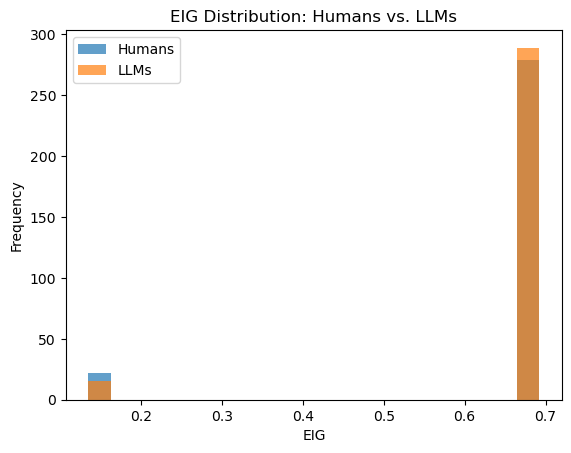

In [14]:
import matplotlib.pyplot as plt

# Separate LLM and human participants
human_df = df[df['subj'] < 57]  # Example: humans have `subj` IDs < 57
llm_df = df[df['subj'] >= 57]   # Example: LLMs have `subj` IDs >= 57

# Calculate average EIG
avg_eig_human = human_df['EIG'].mean()
avg_eig_llm = llm_df['EIG'].mean()

print(f"Average EIG - Humans: {avg_eig_human}")
print(f"Average EIG - LLMs: {avg_eig_llm}")

# Visualize the distribution of EIG
plt.hist(human_df['EIG'], alpha=0.7, label='Humans', bins=20)
plt.hist(llm_df['EIG'], alpha=0.7, label='LLMs', bins=20)
plt.title("EIG Distribution: Humans vs. LLMs")
plt.xlabel("EIG")
plt.ylabel("Frequency")
plt.legend()
plt.show()
